## Trajectoryless Analysis Workshop Activity

In this notebook, we've included instructions on how to run a sample simulation of 
a protein in water and analyze it with live simulation streaming implemented in GROMACS and MDAnalysis.

To run the simulation, first run the following commands in your terminal:
```bash
cd activity
# Preprocess the topology and run the simulation
./run.sh
```

Then, when you see the following line printed to the terminal, 
you can run your analysis code from this notebook:

`IMD: Will wait until I have a connection and IMD_GO orders.`

We've included a template for analysis that currently computes 
and displays the distance between two pairs of proteins live
as their distance fluctuates in the simulation, however, this is just
a sample of what you can do! The comments in the code below show what 
to change to get the analysis code to do something different.


### Setup: Create an MDAnalysis Universe

Run this each time a simulation is ready for a connection to configure a [Universe](https://userguide.mdanalysis.org/stable/universe.html)
to connect to the running simulation.

In [ ]:
from imdclient.IMDREADER import IMDReader
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from utils import update_display, start_interactive_display, stop_interactive_display

u = mda.Universe("sample_simulation/imdgroup.gro", "imd://localhost:8889", buffer_size = 100*1024*1024)


## Analysis

Once your Universe is connected to the running simulation, you can analyze the trajectory
data live!

By default, the time, simulation box, positions, velocities, forces, will be available in the trajectory for use like this:

```python
for ts in u.trajectory:
    ts.time
    ts.box
    ts.positions
    ts.velocities
    ts.forces
```

To modify the simulation settings, see "sample_simulation/imd.mdp".

Remember, in live simulation streaming, you can only iterate through the trajectory once.

To re-run your analysis, press CTRL+C in the termial where 'run.sh' is running and 
re-create the above Universe before re-running the analysis loop below.

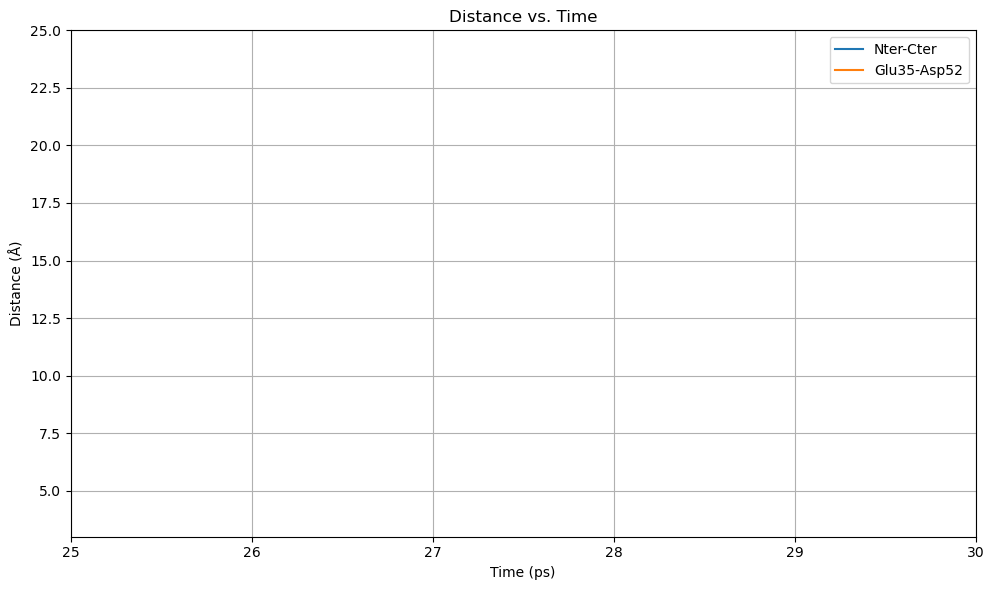

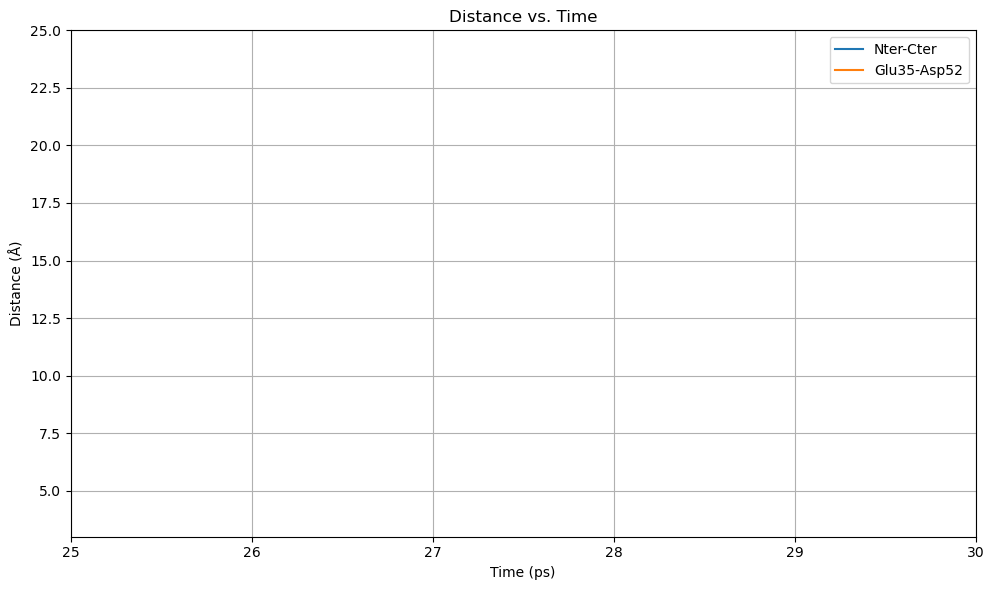

In [ ]:
# Prepare matplot for live visualization
start_interactive_display()

## Distances calculation setup code. CHANGME!

# Setup some residue selections
# See https://userguide.mdanalysis.org/stable/selections.html for more

nter = u.select_atoms("resid 1 and name CA")
cter = u.select_atoms("resid 129 and name CA")
glu35 = u.select_atoms("resid 35 and name CD")
asp52 = u.select_atoms("resid 52 and name CG")

timeWindow = 5.0
dtIMD = 0.010
nTimesPlot = (int)(timeWindow/dtIMD)

time = np.zeros(nTimesPlot, dtype=np.float32)
dist1 = np.zeros(nTimesPlot, dtype=np.float32)
dist2 = np.zeros(nTimesPlot, dtype=np.float32)

fig, ax = plt.subplots(figsize=(10, 6))
p1, = ax.plot([], [], label='Nter-Cter')
p2, = ax.plot([], [], label='Glu35-Asp52')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Distance (Å)')
ax.set_xlim(0, timeWindow)
ax.set_ylim(3, 25)
ax.set_title('Distance vs. Time')
ax.legend()
ax.grid(True)
plt.tight_layout()

update_display(fig)

min_idx = 0
i = 0

## Main simulation loop
for ts in u.trajectory:

    ## The analysis and visualization code go here. CHANGEME!
    idx = i % nTimesPlot
    time[idx] = ts.time
    dist1[idx] = np.linalg.norm(nter.atoms[0].position - cter.atoms[0].position)
    dist2[idx] = np.linalg.norm(glu35.atoms[0].position - asp52.atoms[0].position)

    if i % nTimesPlot == 0:
        min_idx = idx
        ax.set_xlim(time[idx], time[idx] + nTimesPlot*dtIMD)

    if i % timeWindow ==0:
        valid_indices = range(min_idx, idx + 1)
        p1.set_data(time[valid_indices], dist1[valid_indices])
        p2.set_data(time[valid_indices], dist2[valid_indices])
        
        update_display(fig)
        
    i += 1

stop_interactive_display()

